In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from string import punctuation
import re
from nltk.stem import SnowballStemmer


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import emoji
from geotext import GeoText
import boto3

In [2]:
df1 = pd.read_csv('data/train.csv') 
df1.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df2 = pd.read_csv('data/tweets.csv') 
df2.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [4]:
df2['id'] = range(10876, 10876+len(df2))

In [5]:
tweets = pd.concat([df1,df2]).reset_index(drop = True)
tweets

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
18978,22241,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
18979,22242,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
18980,22243,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
18981,22244,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [6]:
# quitar emojis
# quitar stopwords
# quitar puntuacion
# poner todo en minusculas
# homologar paises (los que sabemos)

In [7]:
regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
#stopwords
english_stopwords = stopwords.words('english')

english_stopwords.extend(['dont', 'rt', 'one', 'didnt', 'two', 'û', 'hi', 'cant', '“', 'u', 'im', '’', '”'])
# stemmer español
lemmatizer = WordNetLemmatizer() 
stemmer = SnowballStemmer('english')
#signos de puntuacion
non_words = list(punctuation)

In [8]:
def clean(texto):
    texto = texto.lower()
    texto = ''.join([c for c in texto if c not in non_words])
    texto = ' '.join(s for s in texto.split() if not any(c.isdigit() for c in s))
    texto = re.sub("[.*?]","",texto)
    texto = re.sub('https?://\S+|WWW\.\S+','',texto)
    texto = re.sub("<.*?>+","",texto)
    texto = re.sub("``","",texto)
    texto = re.sub("''","",texto)
    texto = regrex_pattern.sub(r'',texto)
    texto = re.sub('[!@#$]', '', texto)
    
    # tokenize
    tokens =  word_tokenize(texto)
    #Remove stopwords
    tokens = [w for w in tokens if not w in english_stopwords]
    
    return tokens

In [9]:
def lemmatize_tokens(tokens, lemmatizer):
    lemmatized = []
    for item in tokens:
        lemmatized.append(lemmatizer.lemmatize(item))
    return lemmatized

In [10]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [11]:
tweets['clean_text'] = tweets['text'].apply(lambda x: clean(x))
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: lemmatize_tokens(x,lemmatizer))
tweets['clean_text']

0        [deed, reason, earthquake, may, allah, forgive...
1            [forest, fire, near, la, ronge, sask, canada]
2        [resident, asked, shelter, place, notified, of...
3        [people, receive, wildfire, evacuation, order,...
4        [got, sent, photo, ruby, alaska, smoke, wildfi...
                               ...                        
18978    [medium, warned, u, well, advance, wrecked, wh...
18979    [feel, directly, attacked, consider, moonbin, ...
18980    [feel, directly, attacked, consider, moonbin, ...
18981    [ok, remember, outcast, nd, dora, au, au, wrec...
18982                [jake, corway, wrecked, running, irp]
Name: clean_text, Length: 18983, dtype: object

In [12]:
tweets['text']

0        Our Deeds are the Reason of this #earthquake M...
1                   Forest fire near La Ronge Sask. Canada
2        All residents asked to 'shelter in place' are ...
3        13,000 people receive #wildfires evacuation or...
4        Just got sent this photo from Ruby #Alaska as ...
                               ...                        
18978    Media should have warned us well in advance. T...
18979    i feel directly attacked 💀 i consider moonbin ...
18980    i feel directly attacked 💀 i consider moonbin ...
18981    ok who remember "outcast" nd the "dora" au?? T...
18982       Jake Corway wrecked while running 14th at IRP.
Name: text, Length: 18983, dtype: object

In [13]:
tweets['clean_joined'] = tweets['clean_text'].apply(lambda x: " ".join(x))

In [14]:
#Eliminar duplicados
tweets.drop_duplicates(subset=['clean_joined'], keep='last')

,id,keyword,location,text,target,clean_text,clean_joined
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[resident, asked, shelter, place, notified, of...",resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...,...
18977,22240,wrecked,NaN,Had these guys last game n fcked them. Talked ...,0,"[guy, last, game, n, fcked, talked, nonstop, s...",guy last game n fcked talked nonstop shit n st...
18978,22241,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0,"[medium, warned, u, well, advance, wrecked, wh...",medium warned u well advance wrecked whole nig...
18980,22243,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0,"[feel, directly, attacked, consider, moonbin, ...",feel directly attacked consider moonbin amp ji...
18981,22244,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0,"[ok, remember, outcast, nd, dora, au, au, wrec...",ok remember outcast nd dora au au wrecked nerv...


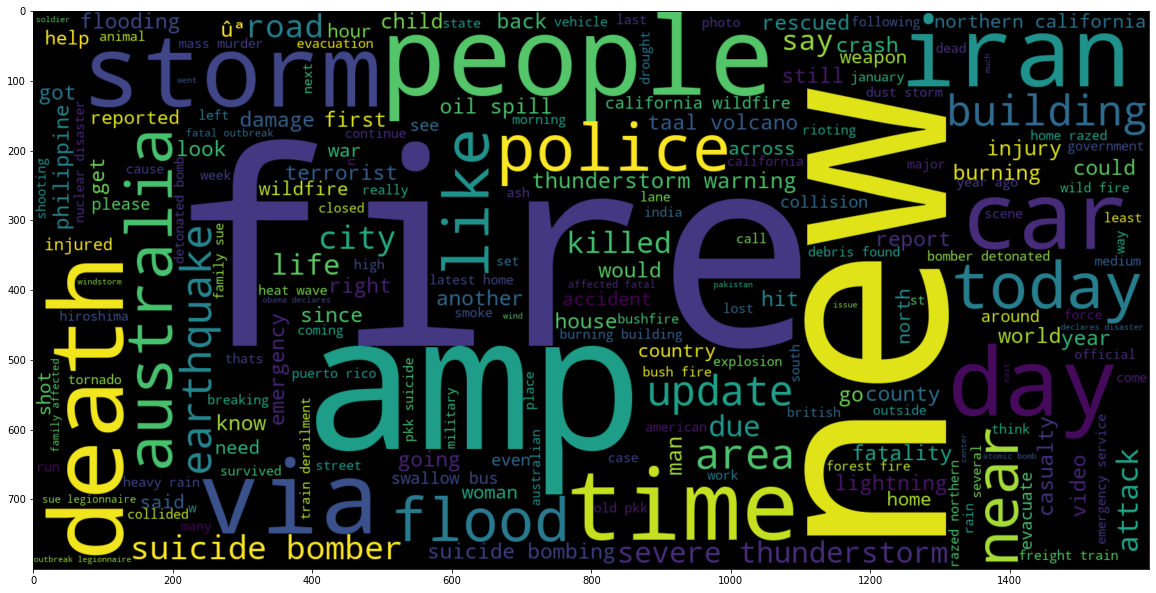

In [15]:
# palabras de tweets reales
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 200 , width = 1600 , height = 800 , stopwords = english_stopwords).generate(" ".join(tweets[tweets.target == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

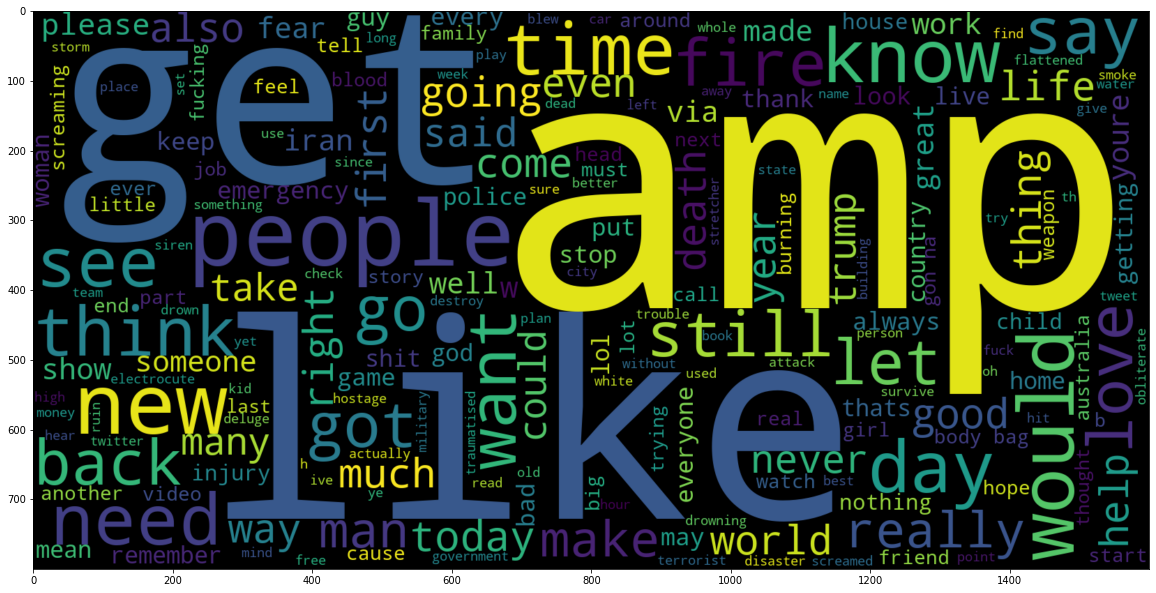

In [16]:
# palabras de tweets no reales
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 200 , width = 1600 , height = 800 , stopwords = english_stopwords).generate(" ".join(tweets[tweets.target == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [17]:
from collections import Counter

def documentNgrams(documents, size):
    ngrams_all = []
    for document in documents:
        tokens = document.split()
        if len(tokens) <= size:
            continue
        else:
            output = list(ngrams(tokens, size))
        for ngram in output:
            ngrams_all.append(" ".join(ngram))
    cnt_ngram = Counter()
    for word in ngrams_all:
        cnt_ngram[word] += 1
    df = pd.DataFrame.from_dict(cnt_ngram, orient='index').reset_index()
    df = df.rename(columns={'index':'words', 0:'count'})
    df = df.sort_values(by='count', ascending=False)
    df = df.head(30)
    df = df.sort_values(by='count')
    return(df)

In [18]:
def plotNgrams(documents):
    unigrams = documentNgrams(documents, 1)
    bigrams = documentNgrams(documents, 2)
    trigrams = documentNgrams(documents, 3)
    
    # Set plot figure size
    fig = plt.figure(figsize = (20, 15))
    plt.subplots_adjust(wspace=.5)

    ax = fig.add_subplot(131)
    ax.barh(np.arange(len(unigrams['words'])), unigrams['count'], align='center', alpha=.5)
    ax.set_title('Unigrams')
    plt.yticks(np.arange(len(unigrams['words'])), unigrams['words'])
    plt.xlabel('Count')

    ax2 = fig.add_subplot(132)
    ax2.barh(np.arange(len(bigrams['words'])), bigrams['count'], align='center', alpha=.5)
    ax2.set_title('Bigrams')
    plt.yticks(np.arange(len(bigrams['words'])), bigrams['words'])
    plt.xlabel('Count')

    ax3 = fig.add_subplot(133)
    ax3.barh(np.arange(len(trigrams['words'])), trigrams['count'], align='center', alpha=.5)
    ax3.set_title('Trigrams')
    plt.yticks(np.arange(len(trigrams['words'])), trigrams['words'])
    plt.xlabel('Count')

    plt.show()

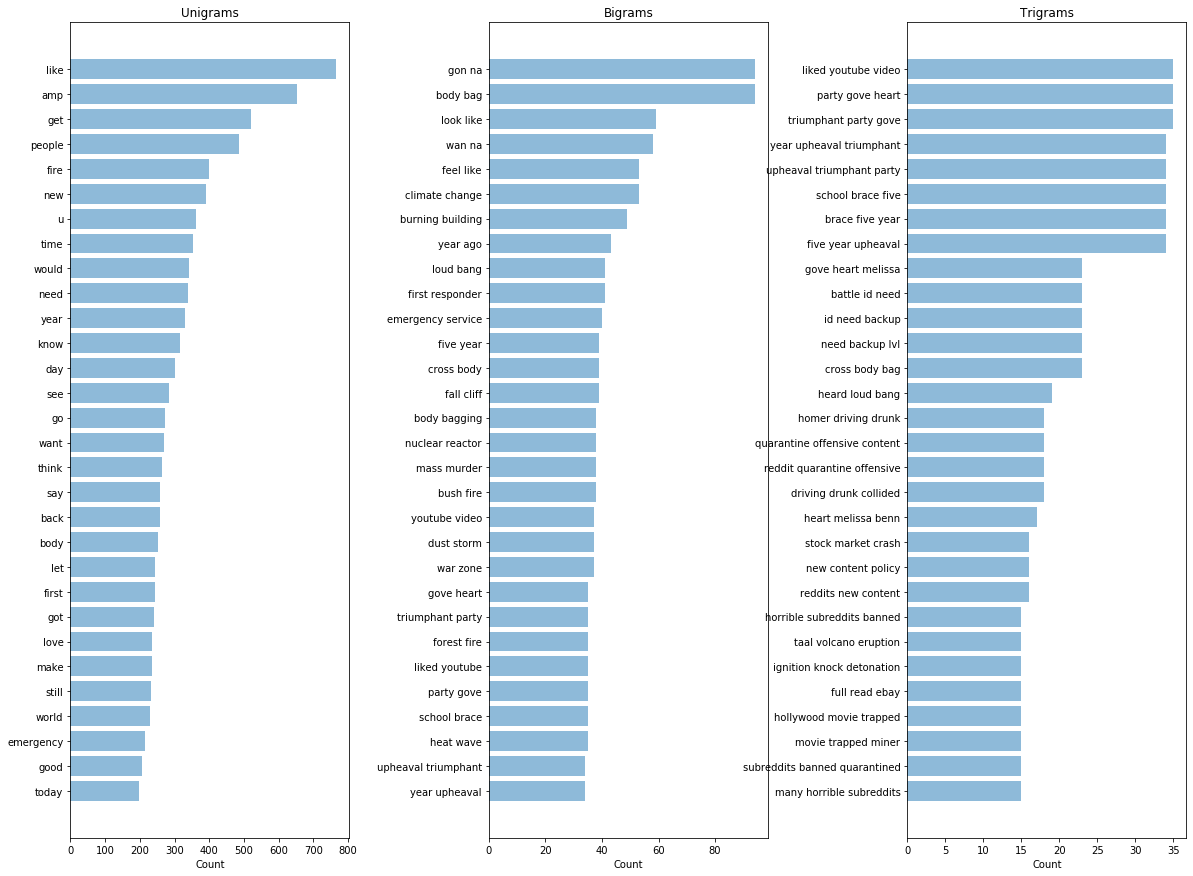

In [19]:
plotNgrams(tweets[tweets.target == 0].clean_joined)

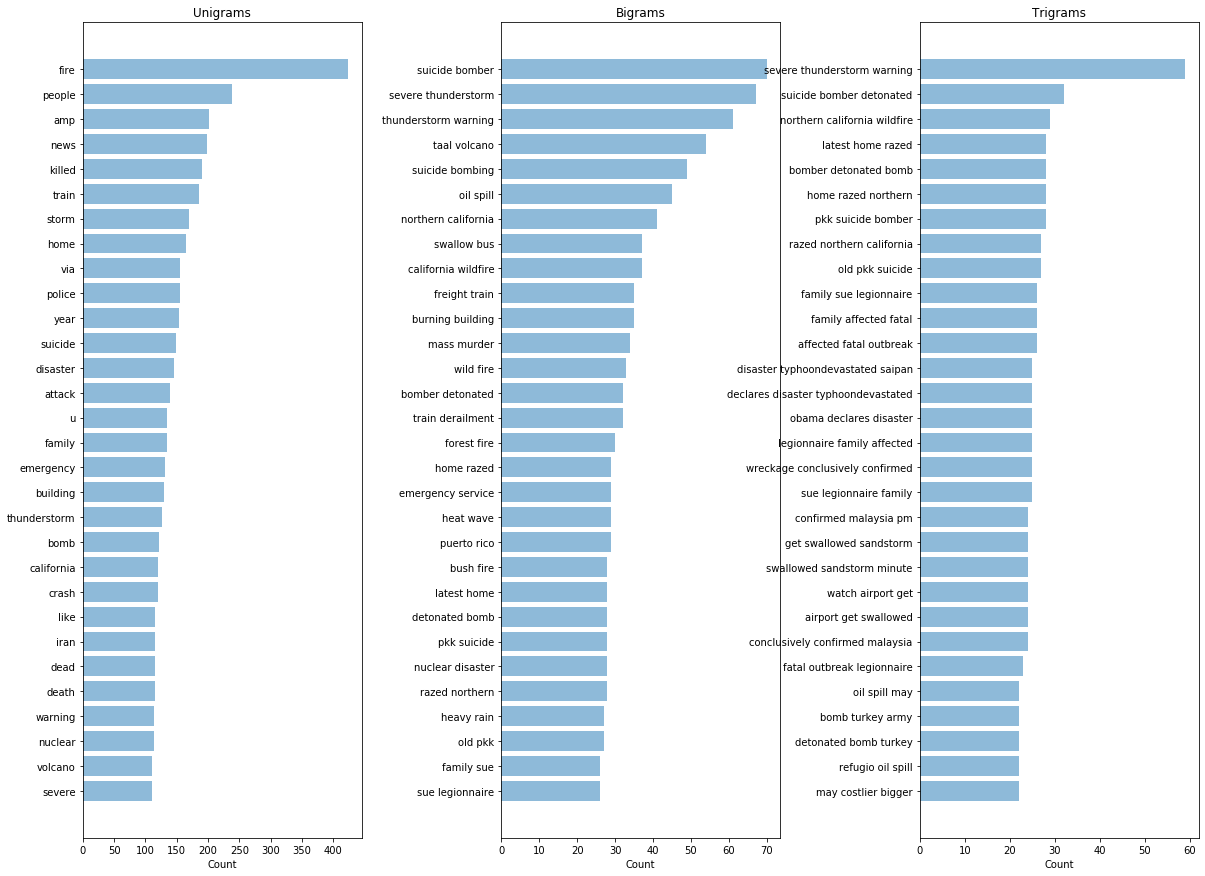

In [20]:
plotNgrams(tweets[tweets.target == 1].clean_joined)

In [21]:
tweets.head()

,id,keyword,location,text,target,clean_text,clean_joined
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[resident, asked, shelter, place, notified, of...",resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...


## Limpieza de Location  y Keywords

In [22]:
tweets['keyword'] = tweets['keyword'].fillna('')
tweets['clean_keyword'] = tweets['keyword'].apply(lambda x: clean(x))
tweets['keyword'] = stem_tokens(tweets['clean_keyword'].astype(str),stemmer)

In [23]:
tweets = pd.get_dummies(tweets, prefix='keyword', columns=['keyword'])

In [24]:
tweets['location'] = tweets['location'].fillna(' ')

In [25]:
def replace_emoji(row):
    return emoji.demojize(row['location'], delimiters=("", " "))

In [26]:
def replace_chars(row):
    res = re.sub('[^a-zA-Z ]', '', row['location_emoji'])
    res = res.replace("  ", " ")
    return res

In [27]:
def get_countries(row):
    res = list(GeoText(row['location_chars']).country_mentions.keys())
    return res[0] if len(res) >= 1 else ''

In [28]:
def get_cities(row):
    res = GeoText(row['location_chars']).cities
    return res[0] if len(res) >= 1 else ''

In [29]:
tweets['location_emoji'] = tweets.apply(lambda row: replace_emoji(row), axis=1)
tweets['location_chars'] = tweets.apply(lambda row: replace_chars(row), axis=1)
tweets['country'] = tweets.apply(lambda row: get_countries(row), axis=1)
tweets['location_emoji'] = tweets.apply(lambda row: replace_emoji(row), axis=1)
tweets['location_chars'] = tweets.apply(lambda row: replace_chars(row), axis=1)
tweets['city'] = tweets.apply(lambda row: get_cities(row), axis=1)
tweets.drop(columns=['location', 'location_emoji', 'location_chars'], inplace=True)

## Variables Resultantes del Feature Engineering

In [30]:
tweets['word_count'] = tweets['text'].apply(lambda x: len(str(x).split())) # cantidad de palabras
tweets['unique_word_count'] = tweets['text'].apply(lambda x: len(set(str(x).split()))) # cantidad de palabras unicas
tweets['stop_words_count'] = tweets['text'].apply(lambda x: len([chars for chars in str(x) if chars in english_stopwords ]))

# Representación del texto

In [31]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import boto3

In [32]:
tokenizer = Tokenizer(num_words=100000, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets["clean_joined"])
word_index = tokenizer.word_index

In [33]:
tweets["sequences"] = tokenizer.texts_to_sequences(tweets["clean_joined"])
tweets.head()

,id,text,target,clean_text,clean_joined,clean_keyword,keyword_['ablaze'],keyword_['accident'],keyword_['aftershock'],keyword_['ambulance'],...,keyword_['wreck'],keyword_['wreckage'],keyword_['wrecked'],keyword_[],country,city,word_count,unique_word_count,stop_words_count,sequences
0,1,Our Deeds are the Reason of this #earthquake M...,1,"[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u,[],0,0,0,0,...,0,0,0,1,,,13,13,23,"[5195, 405, 140, 87, 1751, 2737, 7]"
1,4,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada,[],0,0,0,0,...,0,0,0,1,,,7,7,13,"[130, 4, 151, 846, 12200, 12201, 1078]"
2,5,All residents asked to 'shelter in place' are ...,1,"[resident, asked, shelter, place, notified, of...",resident asked shelter place notified officer ...,[],0,0,0,0,...,0,0,0,1,,,22,20,45,"[867, 1026, 1752, 215, 6260, 672, 361, 1752, 2..."
3,6,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...,[],0,0,0,0,...,0,0,0,1,,,8,8,21,"[5, 2562, 161, 361, 450, 143]"
4,7,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...,[],0,0,0,0,...,0,0,0,1,,,16,15,41,"[29, 847, 272, 12202, 2375, 158, 161, 12203, 100]"


In [34]:
max_ = 0
for i in list(tweets["sequences"].values):
    if len(i) > max_:
        max_ = len(i)
print("tweet con mas tokens", max_)

tweet con mas tokens 23


In [35]:
tweets["sequences"] = pad_sequences(tweets["sequences"], maxlen=max_, padding="post").tolist()
tweets.head()

,id,text,target,clean_text,clean_joined,clean_keyword,keyword_['ablaze'],keyword_['accident'],keyword_['aftershock'],keyword_['ambulance'],...,keyword_['wreck'],keyword_['wreckage'],keyword_['wrecked'],keyword_[],country,city,word_count,unique_word_count,stop_words_count,sequences
0,1,Our Deeds are the Reason of this #earthquake M...,1,"[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u,[],0,0,0,0,...,0,0,0,1,,,13,13,23,"[5195, 405, 140, 87, 1751, 2737, 7, 0, 0, 0, 0..."
1,4,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada,[],0,0,0,0,...,0,0,0,1,,,7,7,13,"[130, 4, 151, 846, 12200, 12201, 1078, 0, 0, 0..."
2,5,All residents asked to 'shelter in place' are ...,1,"[resident, asked, shelter, place, notified, of...",resident asked shelter place notified officer ...,[],0,0,0,0,...,0,0,0,1,,,22,20,45,"[867, 1026, 1752, 215, 6260, 672, 361, 1752, 2..."
3,6,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...,[],0,0,0,0,...,0,0,0,1,,,8,8,21,"[5, 2562, 161, 361, 450, 143, 0, 0, 0, 0, 0, 0..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...,[],0,0,0,0,...,0,0,0,1,,,16,15,41,"[29, 847, 272, 12202, 2375, 158, 161, 12203, 1..."


In [36]:
from sklearn.decomposition import TruncatedSVD

n_comp = [5,10,15,20]
variance = []

for comp in n_comp:
    svd = TruncatedSVD(n_components=comp)
    svd.fit(tweets["sequences"].tolist())
    variance.append(svd.explained_variance_ratio_.sum())
    print("# de componentes: = %r con varianza = %r"%(comp,svd.explained_variance_ratio_.sum()))

# de componentes: = 5 con varianza = 0.4729516146905814
# de componentes: = 10 con varianza = 0.8033341453003392
# de componentes: = 15 con varianza = 0.9893180221131453
# de componentes: = 20 con varianza = 0.9998897700693418


Text(0.5, 0, 'Number of components')

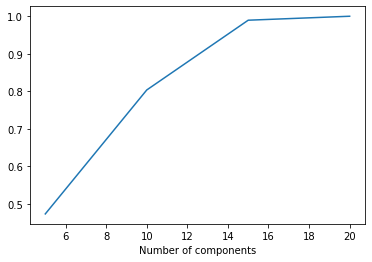

In [37]:
plt.plot(n_comp,variance)
plt.xlabel('Number of components')

In [38]:
svd_model = TruncatedSVD(n_components=15, algorithm='randomized', n_iter=100, random_state=122)
sequences_reduced = svd_model.fit_transform(tweets["sequences"].values.tolist())
tweets['sequences_reduced'] = sequences_reduced.tolist()

In [39]:
df = tweets['sequences_reduced'].apply(pd.Series)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3579.638955,-3482.442249,-279.988646,1303.027894,-2600.428912,-274.026728,898.354109,1540.259124,-546.680010,-177.873400,805.067870,-29.332004,-133.908957,-60.100024,-29.912327
1,7858.481806,2457.835761,9118.382568,1447.859083,-7344.988805,-1343.109229,1426.026466,8356.400508,246.097721,-2933.832107,3159.333970,96.061337,-456.986972,-239.113304,-188.774871
2,4348.646431,198.592695,2271.470597,-409.710280,-903.034330,898.587094,-693.560772,1150.233650,1495.008137,-4127.890657,1319.926481,-719.173782,-144.157609,-141.167611,-71.497543
3,1145.270516,-686.449224,548.834986,-725.174382,1188.491090,-603.408343,-1291.462442,843.637541,292.688985,219.501388,-147.380204,119.666425,-76.440260,-31.716152,-11.147933
4,8303.667890,2760.062261,4623.618583,3014.990035,347.591265,6457.512637,-7641.380150,-7405.076371,-1045.278036,3390.740656,5323.276656,-886.209443,-669.579234,-218.166810,20.793396


In [40]:
newDF = tweets[['unique_word_count', 'stop_words_count']]

In [41]:
tweets = pd.concat([df, newDF], axis=1)
tweets.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,unique_word_count,stop_words_count
0,3579.638955,-3482.442249,-279.988646,1303.027894,-2600.428912,-274.026728,898.354109,1540.259124,-546.680010,-177.873400,805.067870,-29.332004,-133.908957,-60.100024,-29.912327,13,23
1,7858.481806,2457.835761,9118.382568,1447.859083,-7344.988805,-1343.109229,1426.026466,8356.400508,246.097721,-2933.832107,3159.333970,96.061337,-456.986972,-239.113304,-188.774871,7,13
2,4348.646431,198.592695,2271.470597,-409.710280,-903.034330,898.587094,-693.560772,1150.233650,1495.008137,-4127.890657,1319.926481,-719.173782,-144.157609,-141.167611,-71.497543,20,45
3,1145.270516,-686.449224,548.834986,-725.174382,1188.491090,-603.408343,-1291.462442,843.637541,292.688985,219.501388,-147.380204,119.666425,-76.440260,-31.716152,-11.147933,8,21
4,8303.667890,2760.062261,4623.618583,3014.990035,347.591265,6457.512637,-7641.380150,-7405.076371,-1045.278036,3390.740656,5323.276656,-886.209443,-669.579234,-218.166810,20.793396,15,41


In [42]:
tweets = pd.concat([tweets, df.iloc[:,3:]], axis=1)
tweets.head()

,0,1,2,3,4,5,6,7,8,9,...,5,6,7,8,9,10,11,12,13,14
0,3579.638955,-3482.442249,-279.988646,1303.027894,-2600.428912,-274.026728,898.354109,1540.259124,-546.680010,-177.873400,...,-274.026728,898.354109,1540.259124,-546.680010,-177.873400,805.067870,-29.332004,-133.908957,-60.100024,-29.912327
1,7858.481806,2457.835761,9118.382568,1447.859083,-7344.988805,-1343.109229,1426.026466,8356.400508,246.097721,-2933.832107,...,-1343.109229,1426.026466,8356.400508,246.097721,-2933.832107,3159.333970,96.061337,-456.986972,-239.113304,-188.774871
2,4348.646431,198.592695,2271.470597,-409.710280,-903.034330,898.587094,-693.560772,1150.233650,1495.008137,-4127.890657,...,898.587094,-693.560772,1150.233650,1495.008137,-4127.890657,1319.926481,-719.173782,-144.157609,-141.167611,-71.497543
3,1145.270516,-686.449224,548.834986,-725.174382,1188.491090,-603.408343,-1291.462442,843.637541,292.688985,219.501388,...,-603.408343,-1291.462442,843.637541,292.688985,219.501388,-147.380204,119.666425,-76.440260,-31.716152,-11.147933
4,8303.667890,2760.062261,4623.618583,3014.990035,347.591265,6457.512637,-7641.380150,-7405.076371,-1045.278036,3390.740656,...,6457.512637,-7641.380150,-7405.076371,-1045.278036,3390.740656,5323.276656,-886.209443,-669.579234,-218.166810,20.793396


In [44]:
from io import StringIO # python3; python2: BytesIO
import boto3

bucket = 'disaster-tweets-refined' # already created on S3
csv_buffer = StringIO()
tweets.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'tweets/data_location_clean.csv').put(Body=csv_buffer.getvalue())